# EFAS - discharge
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 21-10-2023*<br>

**Introducción:**<br>


In [22]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from tqdm.notebook import tqdm
import yaml

from funciones import *
from metricas_rendimiento import KGE, KGEmod, ECDF

In [23]:
import matplotlib as mpl

def create_cmap(cmap, bounds, name='', specify_color=None):
    """Given the name of a colour map and the boundaries, it creates a discrete colour ramp for future plots
    
    Inputs:
    ------
    cmap:          string. Matplotlib's name of a colourmap. E.g. 'coolwarm', 'Blues'...
    bounds:        list. Values that define the limits of the discrete colour ramp
    name:          string. Optional. Name given to the colour ramp
    specify_color: tuple (position, color). It defines a specific color for a specific position in the colour scale. Position must be an integer, and color must be either a colour name or a tuple of 4 floats (red, gren, blue, transparency)
    
    Outputs:
    --------
    cmap:   List of colours
    norm:   List of boundaries
    """
    
    cmap = plt.get_cmap(cmap)
    cmaplist = [cmap(i) for i in range(cmap.N)]
    if specify_color is not None:
        cmaplist[specify_color[0]] = specify_color[1]
    cmap = mpl.colors.LinearSegmentedColormap.from_list(name, cmaplist, cmap.N)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    return cmap, norm

## Configuración

In [2]:
with open("config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# ruta donde se ubican los datos del Anurio de Aforos
path_anuario = Path('../../data/anuario_aforos/')
path_EFAS = Path('../../data/EFASv5/')
path_camels = Path(cfg['rutas'].get('CAMELS', '../../data/CAMELS-ES/'))

# inicio y fin del periodo de estudio
start = cfg['periodo'].get('inicio', None)
end = cfg['periodo'].get('final', None)
start, end = [pd.to_datetime(i) for i in [start, end]]

# tamaño de las muestras de entrenamiento y validación
train_size = cfg.get('train_size', .6)
assert 0 < train_size <= 1., '"train_size" debe de ser un valor entre 0 y 1'
val_size = cfg.get('val_size', .2)
assert 0 < val_size <= 1., '"train_size" debe de ser un valor entre 0 y 1'
if train_size + val_size > 1:
    val_size = 1 - train_size
    print(f'El valor de "val_size" fue truncado a {val_size:.2f}')
seed = cfg.get('seed', 0)

# sistema de referencia de coordenadas de todos los datos
crs = 'epsg:4326'

# directorio donde guardar los resultados
path_out = Path('../../data/EFASv5/discharge/')
if path_out.exists() is False:
    path_out.mkdir()

In [ ]:
# path_AA = 'C:/Users/jcr693/Documents/anuario_aforos/'

In [ ]:
# # directorios con los datos de EFAS
# path_EFAS = '../data/EFASv5/'
# # path_discharge = f'{path_EFAS}iberia/discharge/'

# # directorio con las capas GIS
# path_GIS = '../data/GIS/'

# # sistema de referencia de coordenadas de todos los datos
# crs = 'epsg:4326'

In [ ]:
# start = '1991-10-01'
# end = '2020-09-30'

## Estaciones

In [11]:
# cargar tabla de atributos de Caravan
atributos = pd.read_csv(path_camels / 'attributes/attributes_caravan_es.csv', index_col=0)
atributos.index = atributos.index.astype(str)
# atributos.index = [id.split('_')[-1] for id in atributos.index]

print('nº de estaciones:\t{0}\nnº de atributos:\t{1}'.format(*atributos.shape))

nº de estaciones:	278
nº de atributos:	10


In [25]:
demarcaciones = gpd.read_file('../../data/cartografia/hidrografia/demarcaciones.shp')
mask = demarcaciones.NOM_DEMAR.isin(['CANTABRICO ORIENTAL', 'CANTABRICO OCCIDENTAL', 'DUERO', 'EBRO', 'GALICIA-COSTA',
                                     'GUADALQUIVIR', 'GUADIANA', 'JUCAR', 'MIÑO-SIL', 'SEGURA', 'TAJO'])
demarcaciones = demarcaciones[mask]

In [12]:
# cargar estaciones
estaciones = gpd.read_file(path_anuario / 'GIS' / 'estaciones.shp')
estaciones.set_index('indroea', drop=False, inplace=True)

# quitar estaciones de la selección
estaciones.loc[~estaciones.index.isin(atributos.index), 'sel'] = 0
borrar = ['2048', '3233', '3251', '3255', '4207', '4212', '4214',
          '5140', '7112', '7121', '8027', '8092', '8140', '8148', '9087', '9255']
estaciones.loc[borrar, 'sel'] = 0

mask_stn = estaciones.sel == 1

In [13]:
# recortar cuencas según la tabla de atributos
cuencas = cuencas.loc[mask_stn, :]
cuencas.index.name = 'gauge_id'

# generar nuevos campos
cuencas['gauge_name'] = estaciones.lugar
cuencas['gauge_lat'] = estaciones.latwgs84
cuencas['gauge_lon'] = estaciones.longwgs84
cuencas['country'] = 'Spain'
cuencas.area_skm = cuencas.area_skm.astype(int)

# eliminar campos
cuencas.drop(['HydroID'], axis=1, inplace=True)

# reordenar
cuencas = cuencas[['gauge_name', 'gauge_lat', 'gauge_lon', 'country', 'area_skm', 'geometry']]

n_cuencas = cuencas.shape[0]
print('nº de cuencas en la capa de polígonos:\t{0}'.format(n_cuencas))

nº de cuencas en la capa de polígonos:	269


## Caudal histórico EFASv5 

In [14]:
Qsim = xr.open_dataset(path_EFAS / 'caudal/estaciones/dis_1990_2023.nc')['discharge'].to_pandas()
Qsim = Qsim.loc[start:end,:]

Qsim.shape

(10593, 269)

In [15]:
# # cargar datos de los NetCDF
# Qsim = xr.open_mfdataset(f'{path_EFAS}caudal/selected_stations/dis_*.nc')['discharge'].compute().to_pandas()

# # recortar al periodo de estudio
# Qsim = Qsim.loc[start:end, :]

# # # exportar series de caudal observado
# # Qsim.to_parquet('../data/EFASv5/caudal/reanalisis_seleccion.parquet')

Traer del PC del trabajo el código que extrae las series de caudal. Ver si es posible mover también los NetCDF originales de EFAS para la Península Ibérica.

Cargar las series del Anuario de Aforos y calcular el KGE de cada estación, y la CDF del conjunto.

## Caudal _Anuario de Aforos_

In [16]:
Qobs = pd.read_parquet(path_anuario / 'caudal.parquet')
Qobs = Qobs[cuencas.index]

Qobs.shape

(10593, 269)

### Rendimiento

In [18]:
cuencas['KGE'] = np.nan
for id in tqdm(cuencas.index):
    cuencas.loc[id, 'KGE'] = KGE(Qobs[id], Qsim[id])[0]
cuencas.sort_values('area_skm',ascending=False, inplace=True)

  0%|          | 0/269 [00:00<?, ?it/s]

In [28]:
cmap, norm = create_cmap('RdBu', [-10, -1, -.75, -.5, -.25, 0, .25, .5, .75, 1], name='KGE')

C:\ProgramFiles\Anaconda3\envs\tfm\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


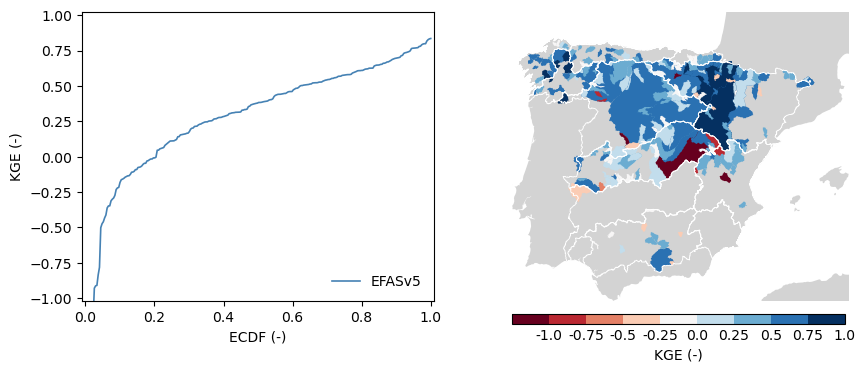

In [36]:
# Create a 1x2 grid of subplots using GridSpec
fig = plt.figure(figsize=(10, 3.75))
gs = gridspec.GridSpec(1, 2)
proj = ccrs.PlateCarree()

# Create the first subplot with PlateCarree projection
ax1 = plt.subplot(gs[1], projection=proj)
ax1.add_feature(cf.NaturalEarthFeature('physical', 'land', '10m', edgecolor=None, facecolor='lightgray'),
               zorder=0)
ax1.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
demarcaciones.plot(ax=ax1, facecolor='none', edgecolor='w', linewidth=0.6, zorder=2)
cuencas.plot(column='KGE', cmap=cmap, norm=norm, alpha=1, ax=ax1, zorder=1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ax1.axis('off')
# colorbar
cax = fig.add_axes([0.555, 0.05, 0.333, 0.025])
cbar = plt.colorbar(sm, location='bottom', shrink=.5, cax=cax)
cbar.set_label('KGE (-)', rotation=0)
cbar.ax.tick_params(size=0)
cax.set_xticklabels(['', '-1.0', '-0.75', '-0.5', '-0.25', '0.0', '0.25', '0.5', '0.75', '1.0'])
# cax.spines[['top', 'left', 'bottom', 'right']].set_visible(False)

ax2 = plt.subplot(gs[0])
ax2.plot(ECDF(cuencas.KGE, plot=False), label='EFASv5', lw=1.2, c='steelblue', ls='-')
ax2.set(xlim=(-.01, 1.01),
       xlabel='ECDF (-)',
       ylim=(-1.02, 1.02),
       ylabel='KGE (-)')
# ax.spines[['top', 'right']].set_visible(False)
ax2.legend(frameon=False, loc=4);

# plt.savefig('../../docs/fig3_rendimiento_EFASv5.jpg', dpi=300, bbox_inches='tight');

In [ ]:
cuencas['KGE_EFAS'] = np.nan
cuencas.loc[estaciones.index, 'KGE_EFAS'] = estaciones.KGE

In [ ]:
# cuencas = [dir for dir in os.listdir(path_AA) if os.path.isdir(os.path.join(path_AA, dir))]
# Qobs = pd.DataFrame(index=pd.date_range(start, end, freq='1d'), dtype=float)
# for cuenca in tqdm(cuencas):
#     ids = estaciones[(estaciones.cuenca == cuenca.lower())].index.to_list()
#     Q = caudal_anuario_aforos(f'{path_AA}{cuenca}/afliq.csv', indroea=ids, start=start, end=end)
#     Qobs = pd.concat((Qobs, Q), axis=1)

In [ ]:
cuenca

In [ ]:
estaciones[(estaciones.cuenca == cuenca.lower())].index.to_list()

In [ ]:
Q = caudal_anuario_aforos(f'{path_AA}{cuenca}/afliq.csv', start=start, end=end)

In [ ]:
Q.columns

In [ ]:
ids

In [ ]:
    # # cargar series temporales
    # data = pd.read_csv(f'{path_AA}{cuenca}/afliq.csv', sep=';', index_col='indroea')
    # data.index = data.index.astype(str)
    # data.fecha = pd.to_datetime(data.fecha, dayfirst=True)

    # # mantener sólo estaciones seleccionadas
    # ids = list(set(data.index).intersection(estaciones.index))
    # data = data.loc[ids, :]
    # if data.shape[0] == 0:
    #     continue

    # # recortar a la fecha de estudio
    # data = data.loc[(data.fecha >= start) & (data.fecha <= end),:]

    # # reformatear series de caudal y nivel
    # Q = pd.DataFrame(index=pd.date_range(data.fecha.min(), data.fecha.max(), freq='1d'), columns=data.index.unique(), dtype=float) 
    # for stn in Q.columns:
    #     data_stn = data.loc[stn].set_index('fecha', drop=True)
    #     Q[stn] = data_stn.caudal

    # Qobs = pd.concat((Qobs, Q), axis=1)

In [ ]:
# exportar series de caudal observado
Qobs.to_parquet('../data/anuario_aforos/caudal_seleccion.parquet')

## Rendimiento EFASv5

In [ ]:
# calcular el coeficiente de eficiencia de Kling-Gupta de cada estación
estaciones['KGE_EFAS'] = pd.Series({id: KGE(Qobs[id], Qsim[id]) for id in estaciones.index}, name='KGE')

In [ ]:
# plot subcuencas
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
subcuencas.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.35)
estaciones.plot(c=estaciones.KGE_EFAS, cmap='coolwarm_r', markersize=10, ax=ax)
# ax.scatter(estaciones.geometry.x, estaciones.geometry.y, s=10, c=estaciones.KGE_EFAS, cmap='coolwarm')
ax.axis('off');

In [ ]:
ecdf_KGE = ECDF(estaciones.KGE_EFAS, plot=True, title='EFASv5', ylabel='KGE (-)')